<a href="https://colab.research.google.com/github/lgvaz/faststyle/blob/master/examples/simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !nvidia-smi

In [2]:
# !pip install -q fastai2
# !pip install -q git+https://github.com/lgvaz/faststyle.git

In [3]:
from fastai2.basics import *
from fastai2.vision.all import *
from faststyle import *

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# root_dir = Path('/content/gdrive/My Drive/')
# save_dir = root_dir/'dl/faststyle'; save_dir.mkdir(exist_ok=True, parents=True)
save_dir = Path('.')

In [5]:
source = untar_data(URLs.COCO_SAMPLE)

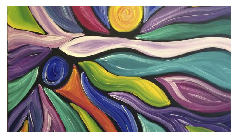

In [6]:
# Fix styles for colab
style_dir = Path('styles')
style_fns = L(style_dir/'abstract.jpg')
show_images([PILImage.create(fn) for fn in style_fns])

In [7]:
dblock = DataBlock(style_blocks, get_items=get_image_files, splitter=RandomSplitter(.1),
                   item_tfms=[Resize(128)],
                   batch_tfms=[*aug_transforms(), NormalizeX.from_stats(*coco_stats)])

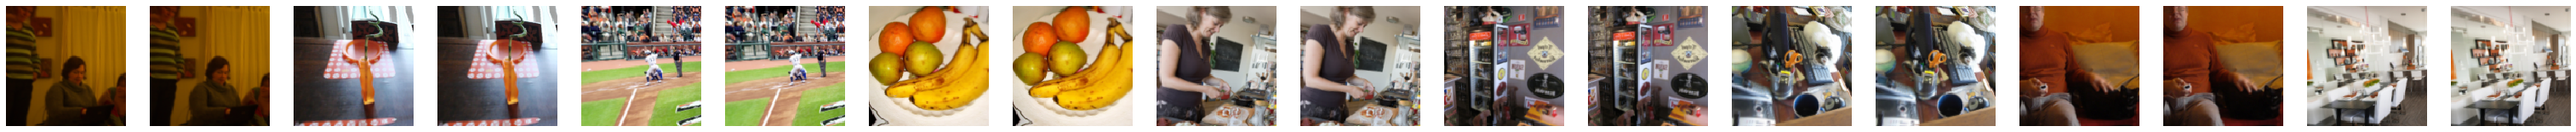

In [8]:
dls = dblock.dataloaders(source, bs=32)
dls.show_batch(rows=1)

In [9]:
get_feats = LayerFeats.from_feat_m(FeatModels.vgg19)

In [10]:
m = TransformerNet()
loss_func = FastStyleLoss(get_feats, stl_w=1e6, tv_w=1000)
learn = style_learner(dls, m, get_feats, style_fns, loss_func=loss_func)

In [11]:
learn.path = save_dir

In [12]:
# learn.lr_find()

In [13]:
learn.fit_one_cycle(1, 1e-3, pct_start=.72)

epoch,train_loss,valid_loss,stl,cnt,tv,time
0,39.854198,44.444138,18.064537,23.398048,2.981543,04:07


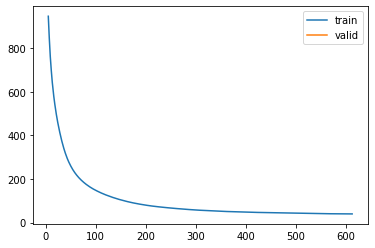

In [14]:
learn.recorder.plot_loss()

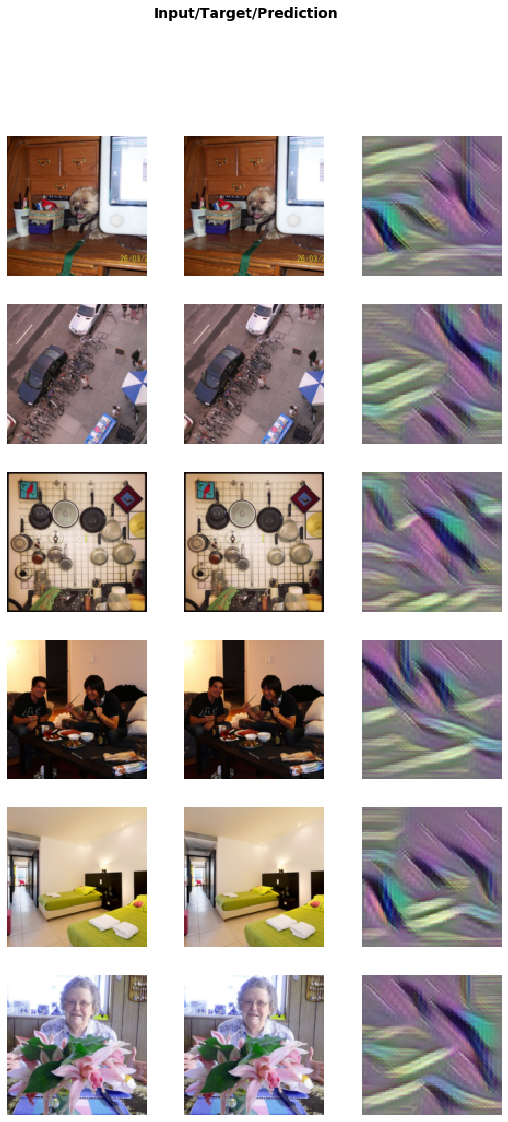

In [15]:
learn.show_results()

In [0]:
learn.save('tn-abstract-512')